# Classifying whether or not employees are likely to resign

In [1]:
import pandas as pd
import numpy as np

from sklearn import  neighbors, svm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,\
    AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB 

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score,\
    mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split,\
    learning_curve
from sklearn.feature_selection import RFE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import itertools
import pickle

DIR_DATA = "data"
DIR_PROCESSED = "processed"
CV_FOLDS = 5

### HR_comma_sep.csv

## Features
* Employee satisfaction level
* Last evaluation
* Number of projects
* Average monthly hours
* Time spent at the company
* Whether they have had a work accident
* Whether they have had a promotion in the last 5 years
* Department
* Salary

## Target
* Whether the employee has left

In [2]:
hr = pd.read_csv(DIR_DATA + '/HR_comma_sep.csv')
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
hr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [4]:
print('Percent who left: {:.2f}'.format(np.sum(hr.left) / len(hr.left) * 100))

Percent who left: 23.81


Turn sales departments and salary (high/medium/low) into category types so that scikit-learn's algorithms can handle them

In [5]:
hr.sales = hr.sales.astype('category').cat.codes
hr.salary = hr.salary.astype('category').cat.codes
hr[["sales","salary"]].head()

,sales,salary
0,7,1
1,7,2
2,7,2
3,7,1
4,7,1


<!-- TEASER_END -->

### Off-the-shelf Classification

Create quick test of basic classification algorithms to see how well each performs with mostly unaltered data

In [6]:
def predict_left(df, clf, test_size=0.2):
    X = df.drop(['left'],1)
    y = df.left 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    print('Training Score: {:.3f}'.format(clf.score(X_train, y_train)))
    print('Testing Score: %.3f' % (clf.score(X_test, y_test)))
    
    print()

In [7]:
classifiers = [RandomForestClassifier(n_jobs=-1),
               RandomForestClassifier(criterion='entropy', n_jobs=-1),
               svm.SVC(),
               LogisticRegressionCV(n_jobs=-1), 
               AdaBoostClassifier(), 
               GradientBoostingClassifier(),
               neighbors.KNeighborsClassifier(n_jobs=-1),
               MultinomialNB(class_prior=[76.19, 23.81])] 

np.random.seed(0)

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    predict_left(hr, clf, test_size=0.4)

Classifier  0
Training Score: 0.998
Testing Score: 0.988

Classifier  1
Training Score: 0.997
Testing Score: 0.986

Classifier  2
Training Score: 0.962
Testing Score: 0.949

Classifier  3
Training Score: 0.780
Testing Score: 0.774

Classifier  4
Training Score: 0.962
Testing Score: 0.964

Classifier  5
Training Score: 0.977
Testing Score: 0.974

Classifier  6
Training Score: 0.951
Testing Score: 0.927

Classifier  7
Training Score: 0.760
Testing Score: 0.765



They all seem to do well, besides svm, with Random Forest doing best regardless of it's criterion at ~98.7% predictive accuracy.

### K-Fold Cross Validation

Let's make sure they consistently produce that score using K-Fold Cross-Validation.

In [8]:
def cross_val_left(hr, clf, cv_folds=CV_FOLDS, drop=['left']):
    X = hr.drop(drop, 1)
    y = hr.left 
    scores = cross_val_score(clf, X, y, cv=cv_folds, n_jobs=-1)#, scoring='roc_auc')
    
    
    
    print('Cross val score: ', sum(scores) / cv_folds )
    print(scores)
    
    print()
    

In [9]:
classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1)]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf)

Classifier  0
Cross val score:  0.992066333178
[ 0.99900033  0.981       0.98633333  0.99933311  0.99466489]

Classifier  1
Cross val score:  0.991866333163
[ 0.99866711  0.98133333  0.98566667  0.99899967  0.99466489]



Great, so they tend to do even better on average, with a score of 99.2% each over 5 cross-validation folds.

### Learning Curve

Now let's see how the classifier improves with more and more training data by plotting a learning curve.

In [10]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
X = hr.drop(['left'],1)
y = hr.left 
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, train_sizes=np.linspace(.1, 1.0, 10), cv=5, n_jobs=-1)


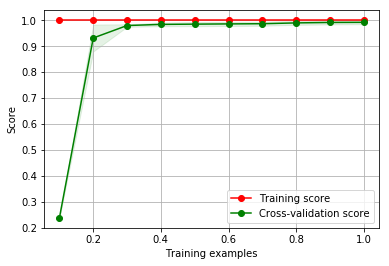

In [11]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
train_sizes = np.linspace(.1,1.0,10)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()
plt.legend(loc="best")
plt.show()

So there seems to be a huge improvement between getting 10% and 20% of the data, with mild improvements after that.

Let's zoom in on the improvements after 40% of the training data is being trained on to get a better picture.

The blue outline around the green cross-validation score is the standard deviation of the predicted scores.

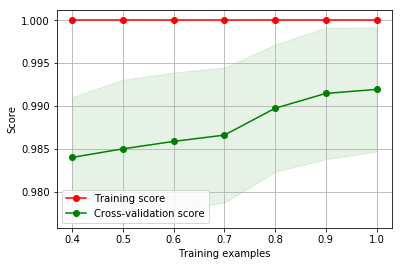

In [12]:
train_scores_mean = np.mean(train_scores, axis=1)[3:] # 0.4 on
train_scores_std = np.std(train_scores, axis=1)[3:]
test_scores_mean = np.mean(valid_scores, axis=1)[3:]
test_scores_std = np.std(valid_scores, axis=1)[3:]
train_sizes = np.linspace(.1,1.0,10)[3:]

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()
plt.legend(loc="best")
plt.show()

## Feature Selection

Now let's do some feature selection by removing the features that least matter

In [13]:
np.random.seed(0)

clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
X = hr.drop(['left'],1)
y = hr.left 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
print(X.columns)
clf.feature_importances_

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')


array([ 0.3475117 ,  0.12315145,  0.17318094,  0.14422289,  0.18418062,
        0.00558285,  0.00098859,  0.01256505,  0.00861591])

Let's start by dropping all features with lower than 0.01 relevance.

It's possible that a feature with a low "relevance" can still matter if the magnitude is great enough, however most of these values are in the same range near zero, so that shouldn't matter.

In [14]:
drop = ['left', 'promotion_last_5years', 'Work_accident', 'sales', 'salary']
for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf, drop=drop)

Classifier  0
Cross val score:  0.991532933111
[ 0.99800067  0.98133333  0.98633333  0.99833278  0.99366455]

Classifier  1
Cross val score:  0.991532910896
[ 0.99833389  0.98166667  0.98566667  0.99833278  0.99366455]



So it seems that dropping all with < 0.01 relevance seems to not affect score much: 

99.20% -> 99.16%

Let's investigate further.

In [15]:
hr.corr()["left"]

satisfaction_level      -0.388375
last_evaluation          0.006567
number_project           0.023787
average_montly_hours     0.071287
time_spend_company       0.144822
Work_accident           -0.154622
left                     1.000000
promotion_last_5years   -0.061788
sales                    0.032105
salary                  -0.001294
Name: left, dtype: float64

Will we get the same results by looking at other metrics? 

Let's see what happens when we drop everything with abs(correlation) < 0.005

In [16]:
drop = ['left',  'sales', 'salary']
classifiers = [RandomForestClassifier(n_estimators=500 ,n_jobs=-1), RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=-1)]#, svm.SVC()]#xgb.XGBClassifier(n_estimators=500, nthread=-1)]# svm.SVC()]

for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf, drop=drop)

Classifier  0
Cross val score:  0.991666355363
[ 0.99800067  0.981       0.986       0.99899967  0.99433144]

Classifier  1
Cross val score:  0.991866310918
[ 0.99833389  0.98166667  0.98633333  0.99866622  0.99433144]



The decrease in accuracy is the same as when we pulled out four features before, even though we only took out half as many.

What happens if we only take out the other two features and leave in the "least correlated"?

In [17]:
drop = ['left', 'promotion_last_5years', 'Work_accident']
for i, clf in enumerate(classifiers):
    print('Classifier ', i)
    
    cross_val_left(hr, clf, drop=drop)

Classifier  0
Cross val score:  0.992199666511
[ 0.99900033  0.98166667  0.98633333  0.99933311  0.99466489]

Classifier  1
Cross val score:  0.991866266489
[ 0.99900033  0.98133333  0.986       0.99899967  0.993998  ]



Hmm. So it seems removing Salary and Sales is what caused the 0.04 percentage point decrease, and still matter somewhat even though they're the least correlated.

The other two features though seem worthless and possibly counterproductive though since removing them managed to increase the RandomForestClassifier's (with Entropy) accuracy

### Recursive Feature Selection

Recursive Feature Selection, or RFE, is a more predictable method of ranking features. 

Let's see if we get the same results as before by looking at what the worst 4 features are


In [18]:
model = RandomForestClassifier(n_estimators=500, n_jobs=-1)
clf = RFE(model, 5)

X = hr.drop(['left'], 1)
y = hr.left 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
print(clf.support_)
print(clf.ranking_)
# Gets same result as feature_importance, which makes sense

[ True  True  True  True  True False False False False]
[1 1 1 1 1 4 5 2 3]


It's the same as before, with 'promotion_last_5years' and 'Work_accident' being the worst features, with Salary and Sales right behind.

That worked out nicely.

But is that true if we use other algorithms with similar accuracy (that RFE is willing to work with)?

In [19]:
classifiers = [AdaBoostClassifier(), 
               GradientBoostingClassifier(),
               LogisticRegressionCV(),
               MultinomialNB()] 

for i, model in enumerate(classifiers):
    clf = RFE(model, 5)

    X = hr.drop(['left'], 1)
    y = hr.left 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
    print("Classifier %d" % i)
    clf.fit(X_train, y_train)
    
    print(clf.ranking_)
    print()
    # Gets same result as feature_importance

Classifier 0
[1 1 1 1 1 5 4 2 3]

Classifier 1
[1 1 1 1 1 3 5 4 2]

Classifier 2
[1 1 2 4 1 1 1 3 5]

Classifier 3
[1 1 2 5 3 1 1 4 1]



Both the high accuracy classifiers (AdaBoost and GradientBoost) view those same 4 as being the lest useful, in similar if not identical orders. Logistic Regression and Multinomial Naive Bayes on the other hand, with their ~77% accuracy only agreed that sales was bad.

Given that all the high accuracy classifiers agree, I think it's safe to say that 'promotion_last_5years' and 'Work_accident' are the worst features

## PCA

Now let's look at what happens when reduce the relevant features down to 2 and 3 dimensions so that we can plot them.

### 2-D

In [20]:
drop = ['left',  'promotion_last_5years', 'Work_accident']

y = np.array(hr.left)

X = np.array(hr.drop(drop,1))
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)

Now that we've done the PCA transformation, let's see how much of the variance is explained per new feature, and overall

In [21]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[ 0.99518845  0.00328358]
0.998472031391


It looks like pretty much all of the variance is being handled by the first dimension, and that we should still get high accuracy since most of the variance in the data is still there.

In [22]:
# Still get good accuracy, ~97%
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
y = np.array(hr.left) 

scores = cross_val_score(clf, X_pca, y, cv=CV_FOLDS, n_jobs=-1)
    
    
    
print('Cross val score: ', sum(scores) / CV_FOLDS )
print(scores)

Cross val score:  0.9572663318
[ 0.96801066  0.92066667  0.93466667  0.97965989  0.98332778]


Despite catching most of the variance, the accuracy of the classifier goes down a lot (3.5 percentage points) and there is a lot more variance in the various cross folds (92.07% <-> 98.33%)

### Now let's plot our 2-Dimensional data

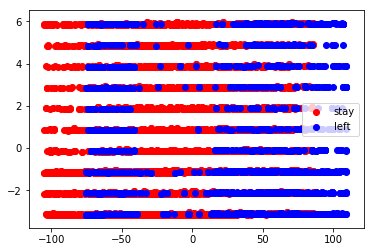

In [23]:
colors = itertools.cycle('rb')
target_ids = range(2)
plt.figure()
for i, c, label in zip(target_ids, colors, ["stay","left"]):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
                c=c, label=label)
plt.legend()
plt.show()

### 3-D

/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


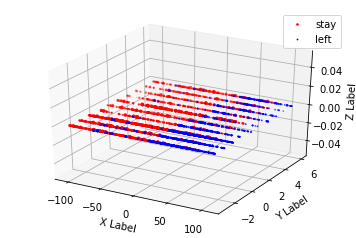

In [24]:
y = np.array(hr.left)

X = np.array(hr.drop(drop,1))
pca = PCA(n_components=3).fit(X)
X_pca = pca.transform(X)

colors = itertools.cycle('rb')
target_ids = range(2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, c, label in zip(target_ids, colors, ["stay","left"]):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],X_pca[y == i, 2],
                c=c, label=label)
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.legend()
plt.show()

Sicne almost all of the variance is in the first dimension, it makes sense that the 3d graph is essentially a 2-D plane.

Now let's check in on the accuracy of the 3-D version

In [25]:
# 3D accuracy is the same as 2D
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
y = hr.left 

scores = cross_val_score(clf, X_pca, y, cv=CV_FOLDS, n_jobs=-1)
    
    
    
print('Cross val score: ', sum(scores) / CV_FOLDS )
print(scores)

Cross val score:  0.971266776704
[ 0.97500833  0.948       0.95666667  0.98399466  0.99266422]


Accuracy seems to be halfway between the 2-D accuracy and the original accuracy at 97.1%, which makes sense.

## Confusion Matrix and Classification Report

In [26]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
X = hr.drop(drop,1)
y = hr.left 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Confusion Matrix

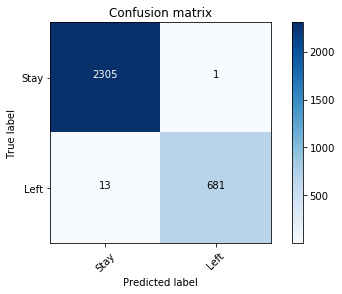

In [27]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=10)

class_names = ["Stay","Left"]

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


plt.show()

As you can see...

### Classification Report

In [28]:
print(classification_report(y_test,y_pred, target_names=class_names))

             precision    recall  f1-score   support

       Stay       0.99      1.00      1.00      2306
       Left       1.00      0.98      0.99       694

avg / total       1.00      1.00      1.00      3000



## Attempt to find department level features, doesn't seem to matter


In [29]:
hr_corr = hr.corr()
hr_corr["sales"]

satisfaction_level       0.003153
last_evaluation          0.007772
number_project           0.009268
average_montly_hours     0.003913
time_spend_company      -0.018010
Work_accident            0.003425
left                     0.032105
promotion_last_5years   -0.027336
sales                    1.000000
salary                   0.000685
Name: sales, dtype: float64

In [30]:
hr.columns.values

array(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'left', 'promotion_last_5years', 'sales', 'salary'], dtype=object)

In [31]:
for col in hr.columns:
    depProperties = hr.groupby('sales').agg({col:[np.size,np.mean]})
    print(depProperties)

      satisfaction_level          
                    size      mean
sales                             
0                 1227.0  0.618142
1                  787.0  0.619822
2                  767.0  0.582151
3                  739.0  0.598809
4                  630.0  0.621349
5                  858.0  0.618601
6                  902.0  0.619634
7                 4140.0  0.614447
8                 2229.0  0.618300
9                 2720.0  0.607897
      last_evaluation          
                 size      mean
sales                          
0              1227.0  0.716830
1               787.0  0.712122
2               767.0  0.717718
3               739.0  0.708850
4               630.0  0.724000
5               858.0  0.715886
6               902.0  0.714756
7              4140.0  0.709717
8              2229.0  0.723109
9              2720.0  0.721099
      number_project          
                size      mean
sales                         
0               1227  3.816626
1    

## Other things to do (Feature Engineering)

- Department level metrics. However, my preliminary exploration in that area didn't seem to improve anything
- Feature Scaling on some of the metrics that are in completely different ranges than the rest of the features, like *average_monthly_hours*. Also didn't seem to improve anything on Random Forest at least.

99.2% is a pretty good accuracy, and it's not as if that's a bad metric since recall and precision are just as high even though the data is unbalanced. So I'm just going to leave it as is.

In [32]:
# Department metrics don't work

hr["is_4"] = hr.sales.apply(lambda x: x== 4)

depProperties = hr.groupby('sales').agg({'promotion_last_5years':np.mean}).values
hr["avg_per_team"] = hr.sales.apply(lambda x: depProperties[x])

In [ ]:
# Do feature scaling  Average_monthly_5_years

# Normalizing waiting time to mean 0 and unit variance
hr.average_montly_hours = hr.average_montly_hours.astype(np.float64)
monthly_hours_scaler = preprocessing.MinMaxScaler()
hr.average_montly_hours = monthly_hours_scaler.fit_transform(hr.average_montly_hours.values.reshape(-1,1))

In [35]:
drop = ['left',  'promotion_last_5years', 'Work_accident', "is_4", "avg_per_team"]

y = np.array(hr.left)

X = np.array(hr.drop(drop,1))
pca = PCA(n_components=7).fit(X)
X_pca = pca.transform(X)

In [34]:
X.shape

(14999, 7)

Cross val score:  0.991733155422
[ 0.9983338887  0.9796666667  0.985         0.9969989997  0.9986662221]
